### 1. Standardize and collapse the apartment API addresses.
### 2. Join the collapsed API addresses with FEMA data.
### 3. Find the nearest building footprint for each joined entry.

In [1]:
# Import all necessary libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
%matplotlib inline
from shapely.geometry import Polygon
from shapely.geometry import Point,Polygon
from pyproj import Proj, Transformer
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
import fiona
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import requests
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from shapely.ops import nearest_points
from pyproj import CRS
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from functools import lru_cache
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from sklearn.neighbors import BallTree
import numpy as np


#!pip install pyarrow
#!pip install geopy
#!pip install fiona

In [2]:
# Load FEMA Data
fema_data_path = '/Users/kd6801/Desktop/HI_map/HI_Structures.gdb'

# List all layers in the File Geodatabase
layers = fiona.listlayers(fema_data_path)

# Read a specific layer into a GeoDataFrame
fema_data = gpd.read_file(fema_data_path, layer=layers[0])


In [3]:
# Load API Data
api_data = pd.read_json('/Users/kd6801/Desktop/Hilo_API/Hilo_apartment.json')

In [4]:
# Load building footprint data
path_to_hilo_parquet = '/Users/kd6801/Desktop/foot-traffic/hilo_full_patterns.parquet'
building_footprints =  pd.read_parquet(path_to_hilo_parquet, engine='pyarrow')

In [5]:
api_data.iloc[2]

id                                    98-Ponahawai-St,-Hilo,-HI-96720
formattedAddress                      98 Ponahawai St, Hilo, HI 96720
addressLine1                                          98 Ponahawai St
addressLine2                                                     None
city                                                             Hilo
state                                                              HI
zipCode                                                         96720
county                                                         Hawaii
latitude                                                    19.722039
longitude                                                 -155.084752
propertyType                                                Apartment
squareFootage                                                  3942.0
lotSize                                                        4574.0
yearBuilt                                                      1919.0
assessorID          

In [6]:
building_footprints.iloc[1]

placekey                                                   22d-222@bp4-jct-f75
safegraph_place_id                         sg:e170329441704027b328f7603705729f
parent_placekey                                            228-222@bp4-jct-hkf
parent_safegraph_place_id                  sg:d4f8d56cb61345e6b33a5a1382a503d7
location_name                                  Happy Valley Seafood Restaurant
safegraph_brand_ids                                                       None
brands                                                                    None
top_category                               Restaurants and Other Eating Places
sub_category                                          Full-Service Restaurants
category_tags                                                     Chinese Food
naics_code                                                            722511.0
latitude                                                             19.710198
longitude                                           

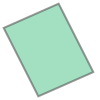

In [7]:
fema_data.iloc[68]['geometry']

In [8]:
fema_data.iloc[68]

BUILD_ID                                                   915522
OCC_CLS                                               Residential
PRIM_OCC                                   Single Family Dwelling
SEC_OCC                                                      None
PROP_ADDR                                                    None
PROP_CITY                                                    None
PROP_ST                                                    Hawaii
PROP_ZIP                                                     None
OUTBLDG                                                      None
HEIGHT                                                        NaN
SQMETERS                                               266.954773
SQFEET                                                2873.474365
H_ADJ_ELEV                                                   None
L_ADJ_ELEV                                                   None
FIPS                                                        15007
CENSUSCODE

In [9]:
# Standardize and collapse addresses in API data
api_data['standardized_address'] = api_data['formattedAddress'].str.lower().replace({'street': 'st', 'road': 'rd'}, regex=True)
api_data['standardized_address'] = api_data['formattedAddress'].str.replace(r'\bapt.*\b|\bunit.*\b', '', regex=True).str.strip()
api_data = api_data.drop_duplicates(subset=['formattedAddress', 'zipCode'])

In [10]:
# Create geometry columns for GeoDataFrames
api_data['geometry'] = api_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
#fema_data['geometry'] = fema_data.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
building_footprints['geometry'] = building_footprints.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

api_gdf = gpd.GeoDataFrame(api_data, geometry='geometry', crs='EPSG:4326')
fema_gdf = gpd.GeoDataFrame(fema_data, geometry='geometry', crs='EPSG:4326')
building_footprints_gdf = gpd.GeoDataFrame(building_footprints, geometry='geometry', crs='EPSG:4326')



In [11]:
joined = gpd.sjoin(api_gdf, fema_gdf, how="inner", op='intersects')

/Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [12]:
print(f"After joining the Apartment API and Fema dataset, we have {len(joined)} overlaps.")

After joining the Apartment API and Fema dataset, we have 75 overlaps.


In [13]:
# # Rename columns in both dataframes if they exist
# if 'index_left' in joined.columns:
#     joined.rename(columns={'index_left': 'index_left_old'}, inplace=True)
# if 'index_right' in joined.columns:
#     joined.rename(columns={'index_right': 'index_right_old'}, inplace=True)
# if 'index_left' in building_footprints_gdf.columns:
#     building_footprints_gdf.rename(columns={'index_left': 'index_left_old'}, inplace=True)
# if 'index_right' in building_footprints_gdf.columns:
#     building_footprints_gdf.rename(columns={'index_right': 'index_right_old'}, inplace=True)

In [14]:
# # Now we make sure they use the same CRS
# print(f"CRS for geoParquet dataframe is {building_footprints_gdf.crs}")
# print(f"CRS for joined dataframe is {joined.crs}")
# building_footprints_gdf = building_footprints_gdf.set_crs(joined.crs, allow_override=True)
# print(f"After alignment,CRS for geoParquet dataframe is {building_footprints_gdf.crs}")
# print(f"After alignment,CRS for joined dataframe is {joined.crs}")

# print(f"There are in total {len(building_footprints_gdf)} entries in the foot traffic data")

In [15]:
# # Check for and drop any geometries that are None or contain NaN coordinates
# building_footprints_gdf = building_footprints_gdf[building_footprints_gdf.geometry.notna()]
# joined = joined[joined.geometry.notna()]
# # Remove any geometries that are invalid
# building_footprints_gdf = building_footprints_gdf[building_footprints_gdf.geometry.is_valid]
# joined = joined[joined.geometry.is_valid]

In [16]:
# # Spatial join API data with FEMA data
# joined_gdf = gpd.sjoin(joined, building_footprints_gdf, how='inner', op='intersects')

In [17]:
# print(f"Through direct gpd.sjoin, we see that there is {len(joined_gdf)} overlap.")

In [18]:
joined.iloc[12]

id                                          41-Laimana-St,-Hilo,-HI-96720
formattedAddress                            41 Laimana St, Hilo, HI 96720
addressLine1                                                41 Laimana St
addressLine2                                                         None
city                                                                 Hilo
state                                                                  HI
zipCode                                                             96720
county                                                             Hawaii
latitude                                                        19.720946
longitude                                                     -155.093607
propertyType                                                    Apartment
squareFootage                                                         NaN
lotSize                                                           15495.0
yearBuilt                             

In [61]:
import geopandas as gpd

# Assuming 'joined' and 'building_footprints_gdf' are already loaded into your environment

# Function to check if a DataFrame is a GeoDataFrame and has valid geometries
def check_geodataframe(gdf, name):
    # Check if it is a GeoDataFrame
    if isinstance(gdf, gpd.GeoDataFrame):
        print(f"'{name}' is a GeoDataFrame.")
    else:
        print(f"'{name}' is not a GeoDataFrame.")
        return  # Stop further checks if it's not a GeoDataFrame
    
    # Check if the geometry column exists and has valid geometries
    if 'geometry' in gdf.columns:
        print(f"'{name}' contains a 'geometry' column.")
        # Check for any invalid geometries
        if gdf['geometry'].is_valid.all():
            print(f"All geometries in '{name}' are valid.")
        else:
            print(f"Some geometries in '{name}' are invalid.")
    else:
        print(f"'{name}' does not contain a 'geometry' column.")

# Perform checks on both GeoDataFrames
check_geodataframe(joined, 'joined')
check_geodataframe(building_footprints_gdf, 'building_footprints_gdf')


'joined' is a GeoDataFrame.
'joined' contains a 'geometry' column.
All geometries in 'joined' are valid.
'building_footprints_gdf' is a GeoDataFrame.
'building_footprints_gdf' contains a 'geometry' column.
Some geometries in 'building_footprints_gdf' are invalid.


In [62]:
import geopandas as gpd

# Repair invalid geometries using buffer(0)
building_footprints_gdf['geometry'] = building_footprints_gdf['geometry'].buffer(0)

# Check if there are still any invalid geometries
if building_footprints_gdf['geometry'].is_valid.all():
    print("All geometries in 'building_footprints_gdf' are now valid.")
else:
    print("There are still invalid geometries in 'building_footprints_gdf'.")


All geometries in 'building_footprints_gdf' are now valid.


In [60]:
building_footprints_gdf = building_footprints_gdf.to_crs(epsg=3857)  # Converting to metric system (meters)
joined = joined.to_crs(epsg=3857)


### Need to use  nearest geometry

In [55]:
from shapely.ops import nearest_points

for index, point in enumerate(joined["geometry"]):
# Prepare an R-tree index on the building footprints
    point_gpd = gpd.GeoSeries(point)
    indices, distances = point_gpd.sindex.nearest(building_footprints_gdf['geometry'],return_distance=True)
    print(distances[index])
    print(indices[0][index], indices[1][index])
    # max distance not working right now, nearest neightbor ?
    # plot the buffers around the partments and shade by aggregate foot count 
    # find index of min(distance)
    # script outputs the large apartments
    # simple rules
   
    


    # the index in the foottraffic dataframe is the row/point closest to the building you are looking at 
    # can also take the minimum 5
    # aggregate foot traffic around the apartment from 2020-2022

# def nearest_building(point, building_gdf, building_index):
#     possible_matches_index = list(building_index.nearest(point.bounds, 1))
#     print(possible_matches_index)
#     possible_matches = building_gdf.iloc[possible_matches_index]
#     nearest_geom = nearest_points(point, possible_matches.unary_union)[1]
#     return nearest_geom


# # Apply the nearest building function to each point in the joined GeoDataFrame
# joined['nearest_building'] = joined['geometry'].apply(lambda x: nearest_building(x, building_footprints_gdf, building_index))



# from shapely.geometry import box

# def nearest_building(point, building_gdf, building_index):
#     # Create a bounding box polygon from the point bounds
#     bounding_box = box(*point.bounds)
#     possible_matches_index = list(building_index.nearest(bounding_box.bounds, 1))
#     possible_matches = building_gdf.iloc[possible_matches_index]
#     nearest_geom = nearest_points(point, possible_matches.unary_union)[1]
#     return nearest_geom

# # Apply the function
# joined['nearest_building'] = joined['geometry'].apply(lambda x: nearest_building(x, building_footprints_gdf, building_index))



1695.014953011986
0 0
1456.7638423792255
1 0
381.1094303625339
2 0
1941.9806514089255
3 0
733.4525104083519
4 0
2394.3752282420437
5 0
210.51923245342726
6 0
7246.137944188459
7 0
488.35421857230574
8 0
1553.176150357135
9 0
4941.435980640634
10 0
3699.419453404896
11 0
1750.3082933173234
12 0
473.398608418366
13 0
902.696163995431
14 0
2795.9793006925506
15 0
4409.743701346932
16 0
1796.6022124298474
17 0
2682.4189838600455
18 0
858.4951892909346
19 0
1444.9256601603702
20 0
3693.0382244068555
21 0
1039.5053191097732
22 0
1963.4197640757307
23 0
1571.892635007062
24 0
589.1322604549206
25 0
3246.6585608850733
26 0
1684.5344370466646
27 0
2343.9267594631297
28 0
1036.524183730061
29 0
1438.8737525131585
30 0
857.4659672798433
31 0
804.6735734539587
32 0
6527.602444031564
33 0
1592.7771923458263
34 0
1714.8608350616933
35 0
2081.538678257411
36 0
1889.1047032835556
37 0
1232.8718018261018
38 0
1492.9799088407028
39 0
287.4152331424035
40 0
1304.3291934256474
41 0
2244.8874863800775
42 0

In [63]:
import geopandas as gpd

# Assuming 'joined' and 'building_footprints_gdf' are GeoDataFrames with geometries
# Ensure the spatial index is created on the building footprints
building_footprints_gdf.sindex

for index, point in enumerate(joined['geometry']):
    # Query the spatial index for the nearest geometry
    # Here, we do not use 'num_results' as it's not accepted in your GeoPandas version
    nearest_indices = list(building_footprints_gdf.sindex.nearest(point.bounds, return_distance=True))

    # Extract the nearest result; it returns indices and distances, so we need to handle it appropriately
    if nearest_indices:
        nearest_index = nearest_indices[0][0]  # index of the nearest building in the DataFrame
        distance = nearest_indices[0][1]  # distance to the nearest building

        print(f"Nearest building index: {nearest_index}, Distance: {distance}")
    else:
        print("No nearest building found")


Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building index: [], Distance: []
Nearest building

In [45]:
# import geopandas as gpd
# from shapely.ops import nearest_points
# from shapely.geometry import Point

# # Sample data creation
# # Assume 'joined' and 'building_footprints_gdf' are already defined GeoDataFrames

# # Creating an R-tree index for the building footprints
# building_footprints_gdf.sindex

# # Loop through each point in the 'joined' GeoDataFrame
# for i, row in joined.iterrows():
#     point = row['geometry']
#     # Query the spatial index for nearest geometries
#     possible_matches_index = list(building_footprints_gdf.sindex.nearest(point.bounds, 1))
#     possible_matches = building_footprints_gdf.iloc[possible_matches_index]
    
#     # Calculate the nearest point among the possible matches and measure the distance
#     nearest_geom = nearest_points(point, possible_matches.unary_union)[1]
#     distance = point.distance(nearest_geom)
    
#     # Assuming you have a maximum distance threshold
#     MAX_DISTANCE = 100  # example distance in meters
#     if distance <= MAX_DISTANCE:
#         print(f"Nearest building at index {possible_matches_index[0]} is within {MAX_DISTANCE} meters.")

# # To plot buffers and shade by foot traffic
# import matplotlib.pyplot as plt

# # Create a buffer around each point (example radius of 50 meters)
# joined['buffer'] = joined['geometry'].buffer(50)

# # Assuming 'foot_traffic' is a column in 'joined' that contains traffic counts
# joined.plot(column='foot_traffic', cmap='viridis', legend=True)
# plt.show()


In [39]:
# building_footprints_gdf.iloc[12]

In [ ]:
# from shapely.geometry import Point, box
# from shapely.ops import nearest_points

# def nearest_building(point, building_gdf, building_index):
#     # Ensure that 'point' is a Shapely Point
#     if not isinstance(point, Point):
#         raise TypeError(f"The 'point' argument must be a Shapely Point object, got {type(point)}")
    
#     bounding_box = box(*point.bounds)
#     # Retrieve the index of the nearest polygon from the R-tree index
#     possible_matches_index = list(building_index.nearest(bounding_box.bounds, 1))
#     # Get the nearest polygon
#     possible_matches = building_gdf.iloc[possible_matches_index]
#     # Find the nearest point in the nearest polygon to our 'point'
#     nearest_geom = nearest_points(point, possible_matches.unary_union)[1]
#     # Return the nearest geometry
#     return nearest_geom


In [ ]:

# joined['nearest_building'] = joined.apply(
#     lambda row: nearest_building(row.geometry, building_footprints_gdf, building_index),
#     axis=1
# )
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import KDTree
import numpy as np

# Assuming `df_apartments` is your dataset of apartments and `df_buildings` is your dataset of building footprints

# Convert apartments data into a GeoDataFrame
gdf_apartments = gpd.GeoDataFrame(
    api_data,
    geometry=gpd.points_from_xy(api_data.longitude, api_data.latitude),
    crs="EPSG:4326"
)

# Convert buildings data into a GeoDataFrame
gdf_buildings = gpd.GeoDataFrame(
    building_footprints_gdf,
    geometry=gpd.points_from_xy(building_footprints_gdf.longitude, building_footprints_gdf.latitude),
    crs="EPSG:4326"
)

# Optionally, you might want to convert coordinates to a metric system to simplify distance calculation
gdf_apartments = gdf_apartments.to_crs(epsg=3857)  # Converting to metric system (meters)
gdf_buildings = gdf_buildings.to_crs(epsg=3857)  # Converting to metric system (meters)

# Build a spatial index for buildings
spatial_index = gdf_buildings.sindex

# Function to find the closest building to each apartment
def closest_building(apartment):
    possible_matches_index = list(spatial_index.nearest(apartment.geometry.bounds, 1))
    possible_matches = gdf_buildings.iloc[possible_matches_index]
    closest = possible_matches.distance(apartment.geometry).idxmin()
    return gdf_buildings.loc[closest]

# Apply the function to each apartment
gdf_apartments['closest_building'] = gdf_apartments.apply(closest_building, axis=1)

# Now gdf_apartments has a new column with the closest building information


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
joined.plot(ax=ax, color='blue', label='Joined Entries')
building_footprints_gdf.plot(ax=ax, color='green', label='Building Footprints', markersize=5)
plt.legend()
plt.show()


In [ ]:
len(joined_gdf)

The plot appears to be a visualization of two sets of geospatial data:

- **Joined Entries (in blue):** These represent the locations where the API data and FEMA data have intersecting points after a spatial join, indicating where apartments identified by the API are matched with FEMA's dataset of building locations.
- **Building Footprints (in green):** These are the locations of buildings as outlined by the footprint data.

What we can deduce from the plot is:

1. **Clustering:** There seems to be a cluster of buildings (green points) where several joined entries (blue points) are located. This suggests a higher density of buildings in certain areas which could correspond to a city center or urban residential area.
   
2. **Spatial Relationship:** The blue points (joined entries) are within or very close to the green points (building footprints), which suggests that the spatial join has been successful to a certain extent, aligning the data from the two different sources.

3. **Coverage:** We are only looking at aprtment buildings, which indicate strong correlation between the hot spot of foot traffic data and apartments in Hilo.

4. **Observation:** If we look at the latitude values (y-axis), we can see the range is quite small, suggesting that this is a localized area.

In [ ]:
# import geopandas as gpd
# import contextily as ctx
# import matplotlib.pyplot as plt

# # Ensure that your GeoDataFrame 'joined' has a CRS set
# joined.crs = "EPSG:4326"  # Set it to WGS 84 if it's not already set

# # Convert to EPSG:3857 for mapping
# joined = joined.to_crs(epsg=3857)
# building_footprints_gdf = building_footprints_gdf.to_crs(epsg=3857)

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 10))
# joined.plot(ax=ax, color='blue', label='Joined Entries', markersize=5)
# building_footprints_gdf.plot(ax=ax, color='green', label='Building Footprints', markersize=5)

# try:
#     # Add the basemap with zoom level set
#     ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)  # You might need to adjust the zoom level
# except Exception as e:
#     print("An error occurred while fetching the basemap:", e)

# plt.legend()
# plt.show()


In [ ]:
#!pip install contextily

In [ ]:
from shapely.geometry import Point
import geopandas as gpd

# Create a GeoSeries of points
points = gpd.GeoSeries([Point(x, y) for x, y in zip(range(10), range(10))])
point_index = points.sindex

# Query the index for the nearest geometry to a single point
result = point_index.nearest(Point(1, 1))
print(result)  # This will show the index of the nearest point


In [ ]:
from shapely.geometry import box
import geopandas as gpd

# Continuing from the previous example
# Create another GeoSeries of geometries to search against the first
boxes = gpd.GeoSeries([box(4.9, 4.9, 5.1, 5.1), box(7, 7, 8, 8)])
result = point_index.nearest(boxes, return_distance=True)
print(result)  # This will show indices and distances to nearest points


In [ ]:
# from shapely.geometry import Point, Polygon
# from pyproj import Proj, Transformer

# # Define projections
# proj_wgs84 = Proj(proj='latlong', datum='WGS84')
# proj_utm = Proj(proj="utm", zone=5, datum='WGS84')  # Adjust zone based on your location

# # Create a transformer
# transformer_to_utm = Transformer.from_proj(proj_wgs84, proj_utm, always_xy=True)
# transformer_to_wgs84 = Transformer.from_proj(proj_utm, proj_wgs84, always_xy=True)

# def buffer_in_meters(lon, lat, meters):
#     """
#     Buffer a geographic point defined in latitude and longitude by a specified distance in meters,
#     transforming it to UTM coordinates for buffering, then converting back to WGS84.

#     Parameters:
#     - lon (float): Longitude of the point in decimal degrees.
#     - lat (float): Latitude of the point in decimal degrees.
#     - meters (float): The buffer distance in meters.

#     Returns:
#     - shapely.geometry.polygon.Polygon or None: A polygon representing the buffered area around the point in WGS84 coordinates.
#       Returns None if the buffered polygon is empty.

#     The function performs coordinate transformations to UTM for accurate distance measurement, buffers the point, and 
#     then transforms the buffered polygon's coordinates back to WGS84 for compatibility with geographic applications. This method 
#     ensures more accurate distance calculations than buffering directly in geographic coordinates.
#     """
#     # Transform point to UTM
#     x, y = transformer_to_utm.transform(lon, lat)
    
#     # Create point and buffer in UTM
#     point_utm = Point(x, y)
#     buffered_point_utm = point_utm.buffer(meters)
    
#     # Convert buffered polygon to WGS84
#     if buffered_point_utm.is_empty:
#         return None
#     else:
#         exterior_coords = [(x, y) for x, y in zip(*buffered_point_utm.exterior.coords.xy)]
#         transformed_coords = [transformer_to_wgs84.transform(x, y) for x, y in exterior_coords]
#         polygon_wgs84 = Polygon(transformed_coords)
#         return polygon_wgs84


In [ ]:
# # Call the above function
# building_footprints_gdf['geometry'] = building_footprints_gdf.apply(
#     lambda row: buffer_in_meters(row['longitude'], row['latitude'], 10), axis=1)